<a href="https://colab.research.google.com/github/vicgalle/sgmcmc-force/blob/master/Samplers_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Grab newest JAX version.
!pip install --upgrade -q jax==0.1.54 jaxlib==0.1.37

use_tpu = True
if use_tpu:
# Make sure the Colab Runtime is set to Accelerator: TPU.
  import requests
  import os
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
  print(config.FLAGS.jax_backend_target)

     |████████████████████████████████| 256kB 3.3MB/s 
     |████████████████████████████████| 25.4MB 1.0MB/s 
grpc://10.111.144.170:8470


In [0]:
import jax
import jax.numpy as np
from jax import random

key = random.PRNGKey(1)

In [19]:
d = 2
N = 6

key, subkey = random.split(key)
x0 = 3. + 0.5*random.normal(key, (N, d))
print(x0)

[[2.7672675 2.6938655]
 [2.7214782 3.8615785]
 [3.2499273 3.3816602]
 [3.2314065 2.6572065]
 [2.6736882 2.9825811]
 [3.3671162 3.4524536]]


In [0]:
eta = 0.1
s = 1.
h = 2*s**2

def K(x):
    xmx = np.expand_dims(x, 0) - np.expand_dims(x, 1)
    norm = np.einsum('ijk,ijk->ij', xmx, xmx)
    return np.exp(-(norm)/h)

def g_K(x):
    # we avoid calling autograd since the function is non-scalar, for better efficiency
    xmx = np.expand_dims(x, 0) - np.expand_dims(x, 1)
    return np.expand_dims(K(x), -1) * (2.*xmx/h)

def logp(x):
    # Standard Gaussian target
    return -np.sum(x**2)

In [0]:
from jax import grad, jit

def svgd(x0, logp, T = 100):
    
    x = x0
    g_logp = grad(logp)

    update_svgd = jit( lambda x : K(x) @ g_logp(x) + g_K(x).sum(0) ) 

    for i in range(T):
        x = x + eta * update_svgd(x)   
    return x

In [22]:
x = svgd(x0, logp, T=200)
x

DeviceArray([[-0.42454344, -0.8572843 ],
             [-0.17041917,  0.9470474 ],
             [ 0.00880022,  0.01030205],
             [ 0.68291396, -0.675293  ],
             [-0.9501707 ,  0.12984073],
             [ 0.85428995,  0.44544965]], dtype=float32)

In [23]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(7.778406e-05, dtype=float32),
 DeviceArray(0.62026393, dtype=float32),
 DeviceArray(0.6195759, dtype=float32))

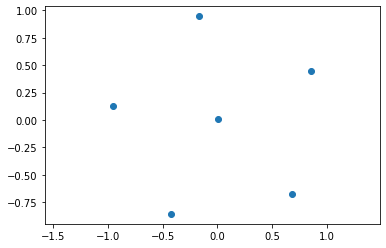

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x[:,0], x[:,1], 'o')
plt.axis('equal');

In [0]:
def sgldr(x0, logp, T = 100, key = key):
    
    x = x0
    g_logp = grad(logp)
    xs = []

    update_sgldr = jit( lambda x, key : ( eta * (K(x) @ g_logp(x) + g_K(x).sum(0)) + np.linalg.cholesky(2 * eta * K(x)) @ random.normal(key, (N, d)), random.split(key)[0] ) )

    for i in range(T):
        x_upd, key = update_sgldr(x, key)
        x = x + x_upd
        xs.append(x)
    return x, xs

In [26]:
x, xs = sgldr(x0, logp, 200, key)
x

DeviceArray([[ 1.4336698 , -0.02702418],
             [-0.05222909,  0.7598193 ],
             [-0.06846839, -0.53038466],
             [-0.81457686, -0.25579137],
             [-0.06573653,  0.9449078 ],
             [-0.74009824,  1.5039665 ]], dtype=float32)

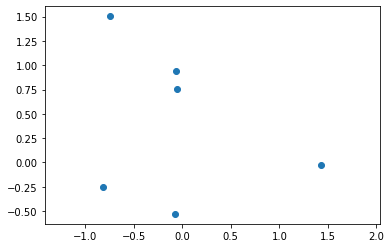

In [27]:
plt.plot(x[:,0], x[:,1], 'o')
plt.axis('equal');

In [28]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(0.1740045, dtype=float32),
 DeviceArray(0.73741376, dtype=float32),
 DeviceArray(0.7214754, dtype=float32))

In [0]:
def sgd(x0, logp, T = 100):
    
    x = x0
    g_logp = grad(logp)

    update_sgd = jit( lambda x : g_logp(x) ) 

    for i in range(T):
        x = x + eta * update_sgd(x)   
    return x

In [0]:
x = sgd(x0, logp, T = 200)

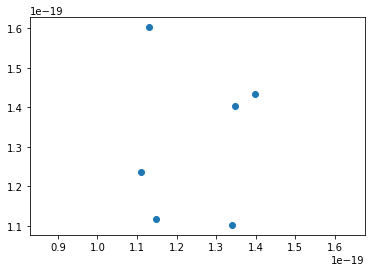

In [31]:
plt.plot(x[:,0], x[:,1], 'o')
plt.axis('equal');

In [32]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(1.280825e-19, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32))

In [0]:
def sgld(x0, logp, T = 100, key = key):
    
    x = x0
    g_logp = grad(logp)
    xs = []

    update_sgld = jit( lambda x, key : ( (eta * g_logp(x)) + np.linalg.cholesky(2 * eta * np.eye(N)) @ random.normal(key, (N, d)), random.split(key)[0] ) )

    for i in range(T):
        x_upd, key = update_sgld(x, key)
        x = x + x_upd
        xs.append(x)
    return x, xs

In [0]:
x, xs = sgld(x0, logp, T = 200)

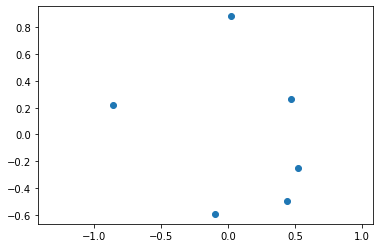

In [0]:
xs = np.asarray(xs)
plt.plot(xs[-1,:,0], xs[-1, :,1], 'o')
plt.axis('equal');

In [0]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(0.04436448, dtype=float32),
 DeviceArray(0.48139596, dtype=float32),
 DeviceArray(0.5093883, dtype=float32))

In [0]:
def sgdm(x0, logp, T = 100, alpha = 0.5):
    
    x = x0
    g_logp = grad(logp)

    update_sgd = jit( lambda x : g_logp(x) ) 
    m = np.zeros_like(x)

    for i in range(T):
        m = alpha * m + eta * update_sgd(x)   
        x = x + m
    return x

In [0]:
x = sgdm(x0, logp, T = 200, alpha=0.5)

In [0]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(8.837335e-31, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32))

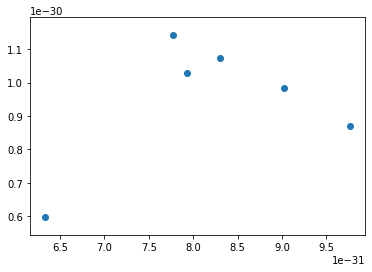

In [0]:
plt.plot(x[:,0], x[:,1], 'o')
plt.axis('equal');

In [0]:
def sgdmr(x0, logp, T = 100, alpha = 0.9):
    
    x = x0
    g_logp = grad(logp)

    update_sgdm1 = jit( lambda x, m : K(x) @ m + g_K(x).sum(0) ) 
    update_sgdm2 = jit( lambda x : K(x) @ g_logp(x) + g_K(x).sum(0) ) 
    m = np.zeros_like(x0)

    for i in range(T):
        x = x + eta * update_sgdm1(x, m)
        m = alpha * m + eta * update_sgdm2(x)
    return x

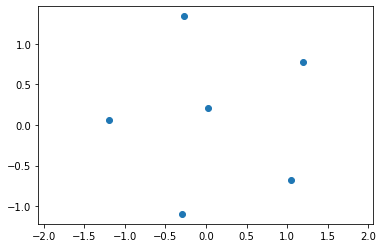

In [0]:
x = sgdmr(x0, logp, T=50)
plt.plot(x[:,0], x[:,1], 'o')
plt.axis('equal');

In [0]:
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(0.09437323, dtype=float32),
 DeviceArray(0.8222229, dtype=float32),
 DeviceArray(0.82081527, dtype=float32))

In [0]:
x = svgd(x0, logp, T=50)
x.mean(), x[:, 0].std(), x[:, 1].std()

(DeviceArray(-3.1024218e-05, dtype=float32),
 DeviceArray(0.6126483, dtype=float32),
 DeviceArray(0.6195676, dtype=float32))